<a href="https://colab.research.google.com/github/topaz0828/ML_Study/blob/master/Chap11_3%2C4_Training_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chap11-3. 심층 신경망 학습 - 학습된 모델 재사용하기

## Set Up

In [ ]:
import os
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

규모가 매우 큰 DNN 모델을 학습 시킬 때 처음부터 새로 학습 시키는 것은 학습 속도가 느린 문제가 있다. 이러한 경우 기존에 학습된 비슷한 DNN모델이 있을 때 **이 모델의 하위층(lower layer)을 가져와 재사용하는 것이 학습 속도를 빠르게 할 수 있을 뿐만아니라 학습에 필요한 Training set도 훨씬 적다.**

예를 들어, 아래의 그림처럼 [CIFAR10](http://www.cs.toronto.edu/~kriz/cifar.html) 데이터셋을 분류(비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭의 10개  클래스)하는 모델 A가 이 있다고 하자. 그런 다음, 분류된 CIFAR10 이미지에서 자동차의 종류를 분류하는 모델인 B를 학습시킨다고 할 때, 학습된 모델 A에서의 일부분(lower layer)을 재사용하여 모델 B를 학습 시킬 수 있다. 이러한 방법을 **Transfer Learning**이라고 한다.

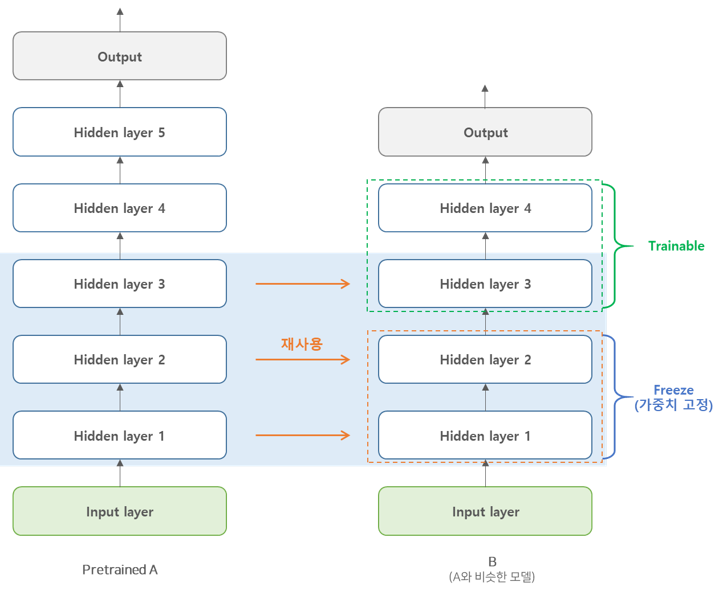



이러한 Transfer Learning을 텐서플로를 이용해서 어떻게 학습시킬 수 있는지에 대해 알아보도록 하자.

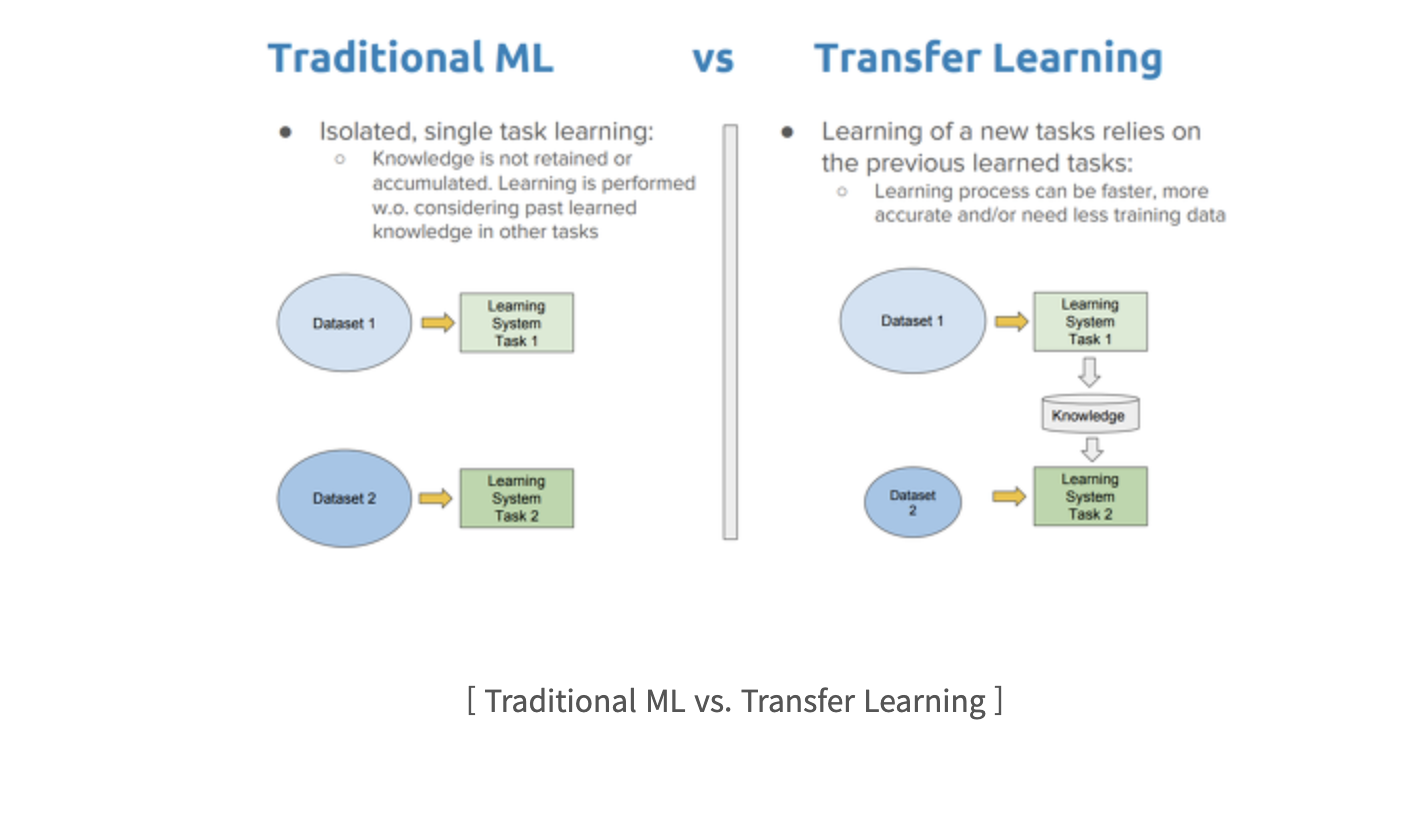 

## 1. 텐서플로 모델 재사용하기

텐서플로에서는 사전에 학습된 모델을 복원하여 새로운 모델을 학습시키는 데 사용할 수 있다. 텐서플로의 [`tf.train.Saver`](https://www.tensorflow.org/api_docs/python/tf/train/Saver)클래스를 이용해 학습된 모델을 저장하고 복원할 수 있게 해준다. `Saver`에 대한 자세한 내용은 

[[러닝 텐서플로]Chap10.1 - 모델 익스포트와 서빙,  Saver](http://excelsior-cjh.tistory.com/163?category=940399)에서 확인할 수 있다. 

먼저, 텐서플로 모델을 재사용하기 위해 모델을 학습 시키기 위한 코드 부터 작성해보도록 하자. 

### 1.1 학습된 모델 저장하기

아래의 예제 코드는, 5개의 hidden layer로 구성된 MNIST 데이터셋을 분류하는 모델이다. `tf.train.Saver`를 이용해 학습된 모델을 `'my_model.ckpt'`에 저장하는 코드이다.

In [ ]:
import os
import numpy as np
import tensorflow as tf

# MNIST Load
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

# Train & TestSet reshape
train_x = train_x.astype(np.float32).reshape(-1, 28*28) / 255.
train_y = train_y.astype(np.int32)
test_x = test_x.astype(np.float32).reshape(-1, 28*28) / 255.
test_y = test_y.astype(np.int32)

# Split Validation set from Train set
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

In [ ]:
def shuffle_batch(inputs, labels, batch_size):
    rnd_idx = np.random.permutation(len(inputs))
    n_batches = len(inputs) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = inputs[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

In [ ]:
reset_graph()

################
# layer params #
################
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

# input layer
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name="inputs")
# output layer
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name='hidden3')
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='hidden4')
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name='hidden5')
    logits = tf.layers.dense(hidden5, n_outputs, name='logits')
    
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# Saver 정의
MODEL_PATH = './model/'
saver = tf.train.Saver()

# 모델을 쉽게 재사용 할 수 있도록 
# 텐서플로 컬렉션(collection)에 저장
train_vars = {'inputs': inputs, 'labels': labels,
              'hidden1': hidden1, 'hidden2': hidden2,
              'hidden3': hidden3, 'hidden4': hidden4,
              'hidden5': hidden5, 'logits': logits}

for key, var in train_vars.items():
    tf.add_to_collection(key, var)

# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels: batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # model save
    save_path = saver.save(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))

epoch: 00, valid. Acc: 0.8768
epoch: 01, valid. Acc: 0.9276
epoch: 02, valid. Acc: 0.9462
epoch: 03, valid. Acc: 0.9544
epoch: 04, valid. Acc: 0.9570


### 1.2 학습된 모델을 이용해 4번째 레이어만 수정하기

이제 '1.1-학습된 모델 저장하기' 에서 저장한 `'my_model.ckpt'`을 이용해, 4번째 hidden layer의 노드 수를 20개로 수정한 뒤 새로운 모델을 학습시키는 코드이다. 아래의 코드는 위의 코드에서 `tf.add_to_collection`에 저장한 `inputs, labels, hidden3 `를 불러온 뒤, `new_hidden4, new_logits`을 추가한 새로운 모델을 학습하여 `my_new_model.ckpt`에 저장하는 코드이다.

In [ ]:
reset_graph()

#################
# layers params #
#################
n_hidden4 = 20  # new hidden
n_outputs = 10  # new output

# import_meta_graph를 통해 model load
MODEL_PATH = './model/'
saver = tf.train.import_meta_graph(os.path.join(MODEL_PATH, 'my_model.ckpt.meta'))

inputs = tf.get_default_graph().get_collection('inputs')[0]
labels = tf.get_default_graph().get_collection('labels')[0]

hidden3 = tf.get_default_graph().get_collection('hidden3')[0]

# 4번째 hidden layer의 노드 수 수정하여 새로운 모델 만듦
new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name='new_hidden4')
new_logits = tf.layers.dense(new_hidden4, n_outputs, name='new_logits')

with tf.name_scope('new_loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=new_logits))
    
################
# Hyper-params #
################
learning_rate = 0.001
n_epochs = 5
batch_size = 50

with tf.name_scope('new_train'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('new_eval'):
    correct = tf.nn.in_top_k(new_logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# New Saver
new_saver = tf.train.Saver()
    
# Train the New Model
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels: batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # save the new model
    save_path = new_saver.save(sess, os.path.join(MODEL_PATH, 'my_new_model.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt
epoch: 00, valid. Acc: 0.9548
epoch: 01, valid. Acc: 0.9732
epoch: 02, valid. Acc: 0.9696
epoch: 03, valid. Acc: 0.9746
epoch: 04, valid. Acc: 0.9752


## 3. 텐서플로를 이용한 Transfer Learning

이번에는 텐서플로를 이용해 '1. Transfer Learning이란'에서 살펴본 Transfer Learning을 구현해보도록 하자. '2.1 학습된 모델 저장하기'의 예제코드를 통해 저장한 `'my_model.ckpt'`에서 `hidden1, hidden2` 레이어는 **Freezing(동결)**한 뒤 재사용 하고, `hidden3`레이어는 Freezing하지 않고 재사용(즉, 학습시킨 다는 의미)한다. 그리고 마지막으로 `hidden4, logits`를 새로 만들어 transfer learning을 수행해보자. 

### 3.1 재사용할 레이어 동결(freezing)하는 방법 (1)

우선, 학습시킬 레이어(`hidden3, hidden4, logits`)와 동결(학습시키지 않을)할 레이어(`hidden1, hidden2`)를 텐서플로의 **[`tf.get_collection()`](https://www.tensorflow.org/api_docs/python/tf/get_collection)**을 이용하여 다음과 같이 설정해줘야 한다.

- **학습시킬 레이어**(`hidden3, hidden4, logits`) : `tf.get_collection()`의 `sope`인자에 정규표현식으로 학습시킬 레이어를 아래의 코드처럼 `'hidden[34]|logits'`라고 지정하면 텐서의 `name`이 매칭되는 레이어를 찾는다. 그런 다음 `optimizer.minimize()`의 `var_list`인자에 넣어주면 된다.

```python
# 학습시킬 레이러 설정 예시
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
             			       scope='hidden[34]|logits')  # 정규표현식
train_op = optimizer.minimize(loss, var_list=train_vars)
```



- **재사용할 레이어**(`hidden1~3`) : 마찬가지로, `tf.get_collection()`의 `scope`인자에 정규표현식으로 `'hidden[123]'`을 넣어준 뒤 `tf.train.Saver()`에 넣어준다.

```python
# 재 사용할 레이어 불러오는 예시
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='hidden[123]') # 정규표현식
restore_saver = tf.train.Saver(reuse_vars)

with tf.Session() as sess:
    restore_saver.restore(sess, './model/my_model.ckpt')
```



이제, 위에서 살펴본 내용을 토대로 재사용할 하위층(low layer)을 동결시킨 후 새로운 레이어를 추가한 새로운 모델을 학습시켜 보자.

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300  # Reusing
n_hidden2 = 50  # Reusing
n_hidden3 = 50  # Reusing
n_hidden4 = 20  # New
n_outputs = 10  # New

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, 
                              activation=tf.nn.relu, name='hidden1')  # Reusing
    hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                              activation=tf.nn.relu, name='hidden2')  # Reusing   
    hidden3 = tf.layers.dense(hidden2, n_hidden3, 
                              activation=tf.nn.relu, name='hidden3')  # Reusing   
    hidden4 = tf.layers.dense(hidden3, n_hidden4, 
                              activation=tf.nn.relu, name='hidden4')  # New  
    logits = tf.layers.dense(hidden4, n_outputs, name='logits')  # new
    
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope='hidden[34]|logits')
    train_op = optimizer.minimize(cross_entropy, var_list=train_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# New Saver 정의
MODEL_PATH = './model/'
new_saver = tf.train.Saver()

# Reusing layer load
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='hidden[123]')
restore_saver = tf.train.Saver(reuse_vars)

# Train the New Model
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    restore_saver.restore(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels: batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # save the new model
    save_path = new_saver.save(sess, os.path.join(MODEL_PATH, 'my_transfer_model.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt
epoch: 00, valid. Acc: 0.9480
epoch: 01, valid. Acc: 0.9516
epoch: 02, valid. Acc: 0.9580
epoch: 03, valid. Acc: 0.9578
epoch: 04, valid. Acc: 0.9584


### 3.2 재사용할 레이어 동결(freezing)하는 방법 (2)

3.1에서 처럼 `optimizer.minimize()`의 `var_list`의 인자로 학습 시킬 레이어를 지정해주는 방법 말고 **[`tf.stop_gradient()`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)**를 사용해 Transfer Learning을 수행할 수 있다. 아래의 예시 코드처럼 동결(freezing)시킬 마지막 레이어(여기서는 `hidden2`) 바로뒤에 `tf.stop_gradient()`를 넣어주면 된다.

```python
# tf.stop_gradient()를 사용한 Transfer Learning
hidden2 = tf.layers.dense(hidden1, ...)
hidden2_stop = tf.stop_gradient(hidden2)
hidden3 = tf.layers.dense(hidden2_stop, ...)
# ...
```



아래의 코드는 3.1의 예제코드를 `tf.stop_gradient()`를 사용해 작성한 코드이다.

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300  # Reusing
n_hidden2 = 50  # Reusing
n_hidden3 = 50  # Reusing
n_hidden4 = 20  # New
n_outputs = 10  # New

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, 
                              activation=tf.nn.relu, name='hidden1')  # Reusing
    hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                              activation=tf.nn.relu, name='hidden2')  # Reusing
    hidden2_stop = tf.stop_gradient(hidden2)  # freezing*****
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, 
                              activation=tf.nn.relu, name='hidden3')  # Reusing   
    hidden4 = tf.layers.dense(hidden3, n_hidden4, 
                              activation=tf.nn.relu, name='hidden4')  # New  
    logits = tf.layers.dense(hidden4, n_outputs, name='logits')  # new
    
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# New Saver 정의
MODEL_PATH = './model/'
new_saver = tf.train.Saver()

# Reusing layer load
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='hidden[123]')
restore_saver = tf.train.Saver(reuse_vars)

# Train the New Model
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    restore_saver.restore(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels: batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # save the new model
    save_path = new_saver.save(sess, os.path.join(MODEL_PATH, 'my_transfer_model2.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt
epoch: 00, valid. Acc: 0.9504
epoch: 01, valid. Acc: 0.9544
epoch: 02, valid. Acc: 0.9554
epoch: 03, valid. Acc: 0.9562
epoch: 04, valid. Acc: 0.9576


### 3.3 동결시킨 층 캐싱하기

3.1과 3.2에서 `hidden1, hidden2`레이어를 재사용함과 동시에 동결(freezing) 시켰는데, 이러한 동결된 레이어는 변하지 않으므로 가장 마지막 동결된 레이어(`hidden2`)에서 나온 출력을 다음과 **캐싱(caching)** 할 수 있다. 

1. 전체 Training Set으로  마지막 동결된 레이어 `hidden2`의 출력을 실행한다. →(충분한 메모리가 있다는 가정하에)
2. 학습하는 동안 Training Set에 대한 미니배치가 아닌 1에서 출력한 `hidden2`레이어의 출력에 대해 미니배치를 만든 다음 레이어에 넣어준다.

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300  # Reusing
n_hidden2 = 50  # Reusing
n_hidden3 = 50  # Reusing
n_hidden4 = 20  # New
n_outputs = 10  # New

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, 
                              activation=tf.nn.relu, name='hidden1')  # Reusing
    hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                              activation=tf.nn.relu, name='hidden2')  # Reusing
    hidden2_stop = tf.stop_gradient(hidden2)  # freezing
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, 
                              activation=tf.nn.relu, name='hidden3')  # Reusing   
    hidden4 = tf.layers.dense(hidden3, n_hidden4, 
                              activation=tf.nn.relu, name='hidden4')  # New  
    logits = tf.layers.dense(hidden4, n_outputs, name='logits')  # new
    
with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
# New Saver 정의
MODEL_PATH = './model/'
new_saver = tf.train.Saver()

# Reusing layer load
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope='hidden[123]')
restore_saver = tf.train.Saver(reuse_vars)

# Train
n_batches = len(train_x) // batch_size

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    restore_saver.restore(sess, os.path.join(MODEL_PATH, 'my_model.ckpt'))
    
    # Caching
    h2_cache = sess.run(hidden2, feed_dict={inputs: train_x})
    h2_cache_valid = sess.run(hidden2, feed_dict={inputs: valid_x})
    
    for epoch in range(n_epochs):
        # mini-batch for hidden2
        shuffle_idx = np.random.permutation(len(train_x))
        hidden2_batches = np.array_split(h2_cache[shuffle_idx], n_batches)
        label_batches = np.array_split(train_y[shuffle_idx], n_batches)
        for hidden2_batch, label_batch in zip(hidden2_batches, label_batches):
            sess.run(train_op, feed_dict={hidden2: hidden2_batch, 
                                          labels: label_batch})
            
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid,
                                                labels: valid_y})
        print('epoch: {:02d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))
    
    # save the new model
    save_path = new_saver.save(sess, os.path.join(MODEL_PATH, 'my_caching_model.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/my_model.ckpt
epoch: 00, valid. Acc: 0.9504
epoch: 01, valid. Acc: 0.9544
epoch: 02, valid. Acc: 0.9554
epoch: 03, valid. Acc: 0.9562
epoch: 04, valid. Acc: 0.9576


## 4. 마무리

이번 포스팅에서는 Transfer Learning에 대해서 알아보았으며, 텐서플로를 이용하여 사전에 학습된 모델을 재사용하고, Transfer Learning을 수행하는 방법에 대해 알아보았다. 위의 코드에 대한 전체코드는 https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap11-Training_DNN/Chap11_3-Training_DNN.ipynb 에서 확인할 수 있다.

##**summary**

[Transfer learning 이란?]

- 트랜스퍼 러닝이란 딥러닝을 feature extractor로만 사용하고 그렇게 추출한 피처를 가지고 다른 모델을 학습하는 것
- 기존의 만들어진 모델을 사용하여 새로운 모델을 만들시 학습을 빠르게 하며, 예측을 더 높이는 방법
- 일반적으로 VGG,ResNet,gooGleNet등 이미 이러한 사전에 학습이 완료된 모델(Pre-Training Model)을 가지고 우리가 원하는 학습에 미세 조정 즉, 작은변화를 이용하여 학습시키는 방법이 Transfer Learning이다. 
- 이미학습된 weight들을 transfer(전송)하여 자신의 model에 맞게 학습을 시키는 방법
- 신경망의 이러한 재학습 과정을 세부 조정(fine-tuning)이라 부름
- 실제로 CNN을 구축하는 경우 대부분 처음부터 (random initialization) 학습하지는 않는다. 
-  ImageNet과 같은 대형 데이터셋을 사용해서 pretrain된 ConvNet 을 사용한다. 

[Fine-tuning 방법]
3가지 방법이 있다.
1. Feature extraction
2. pre-trained model을 모델 구조를 이용
3. 다른 레이어를 고정시키고 일부분 layer를 조정


[Transfer Learning의 종류?]
-  inception (googlenet), ms의 resNet, mobilenet, VGG 등
- Pre trained VGG Model은 ImageNet 기반으로 학습이 된 Model
- Inception v3는 ImageNet이라는 데이터를 분류하는데 학습이 되어 있다.

##**책에서는...**

큰 규모의 DNN의 속도를 빠르게 하기 위해 비슷한 유형의 문제를 처리한 신경망을 찾아보고 하위층을 재사용하는 것이 좋다. 이를 **transfer learning** 이라고 한다.

**1.2.1 텐서플로 모델 재사용하기**

Saver의 **import_meta_graph** 를 통해 다른 모델을 불러오고, **get_operation_by_name()과 get_tensor_by_name()**을 이용하여 훈련 대상을 직접 지정해야 한다. 이 때, tensor는 포인터와 같은 개념이므로 같은 연산을 가리키는 텐서들은 :0, :1, :2 등이 뒤에 붙으며 구분된다. 따라서 연산 이름 뒤에 :0을 붙여주어야 한다.

 
미리 훈련된 모델에 대한 설명이 부족하면 그래프를 직접 뒤져야 하는데, get_operations() method를 활용하면 된다. 연산에 명확한 이름을 사용하고 문서화 해놓는 방법에는 collection이 있다. **add_to_collection** 으로 만들며 **get_collection**으로 불러온다.

다른 모델을 불러와, Collection을 토대로 하위층을 불러오고 모든 변수를 초기화 한 후 하위층의 parameter를 복원하고 상위층을 훈련하면 된다.

 
**11.2.2 다른 프레임워크의 모델 재사용하기**

다른 프레임워크의 모델을 재사용하는 것은 번거로운 작업이다. 파라미터들을 어떻게든 불러와서 모델을 직접 만들고 Assign handle을 구하여 대입해야 한다. 변수 이름에 /Assign이 붙은 Assign operation이 자동으로 정의되어 있으므로 이를 사용하면 된다.


**11.2.3 신경망의 하위층을 학습에서 제외하기**

하위층의 변수를 제외하고 훈련시킬 변수 목록을 optimizer에 var_list로 전달하면 하위층을 학습하지 않는다. 훈련되는 동안 변하지 않는 layer를 **frozen layer**라고 한다.

 
**11.2.4 동결된 층 캐싱하기**

**동결된 층은 변하지 않기 때문에 출력을 캐싱하면 더 빨라질 것이다.** 직접 데이터를 미리 돌려서, 출력값을 저장한 후 배치를 만들어 상위층을 훈련하면 된다. 상위층의 입력값에 feed_dict로 값을 전달하면 하위층을 학습하지 않을 것이다.


**11.2.5 상위층을 변경, 삭제, 대체하기**

원본 모델의 모든 층을 동결 시킨 후 상위층을 동결 해제하여 학습시키거나 (변경), 아예 제거하고 남은 은닉층 중 일부를 동결하여 학습시키거나 (삭제), 상위층의 구성을 변경하거나 추가하여 학습시킬 수 있다 (대체).

 
**11.2.6 모델 저장소**

여러 모델 저장소를 확인하여 자신이 학습하고자 하는 모델과 유사한 모델을 찾을 수 있다. 물론 본인의 모델들을 잘 정리해서 추후 사용하는 것도 중요하다.

예시 : (https://github.com/tensorflow/models)


**11.2.7 비지도 사전훈련**

레이블 된 훈련 데이터를 모으기 힘들다면 비지도 사전훈련을 진행할 수 있다. **Restricted Boltzmann Machines(RBM)**나 **오토 인코더** 같은 **비지도 특성 추출 알고리즘**을 사용하여 초기 신경망을 만들고 역전파 알고리즘으로 파라미터를 튜닝한다. 시간이 오래 걸리고 번거로운 작업이지만 종종 잘 작동한다.

 
**11.2.8 보조 작업으로 사전훈련**

마지막 선택사항은 보조 작업에 신경망을 훈련시켜 하위층을 재사용하는 것이다. 예를 들어 얼굴 인식 시스템의 데이터가 별로 없다면 인터넷에서 무작위로 많은 인물 이미지를 수집한 후 두 개의 다른 이미지가 같은 사람인지 다른 사람인지 감지하는 신경망을 학습하여 하위층을 사용할 수 있다.

 
혹은, 각 훈련 샘플에 대해 샘플의 점수를 출력하도록 한 후 좋은 샘플의 점수가 나쁜 샘플의 점수보다 일정 마진 이상 크게 만드는 비용함수를 사용하는 방법을 **max margin learning** 이라고 한다.

##11.3 고속 옵티마이저

훈련 속도를 높이는 다섯가지 방법이 있다.
* 초기화 전략 적용하기
- 좋은 활성화 함수 사용하기
- 배치 정규화 사용하기
- 사전 훈련된 네트워크 일부 재사용하기
- 지금 소개할 빠른 옵티마이저 적용하기

아래 고솝 옵티마이저는 이 블로그를 토대로 설명한다.
http://shuuki4.github.io/deep%20learning/2016/05/20/Gradient-Descent-Algorithm-Overview.html

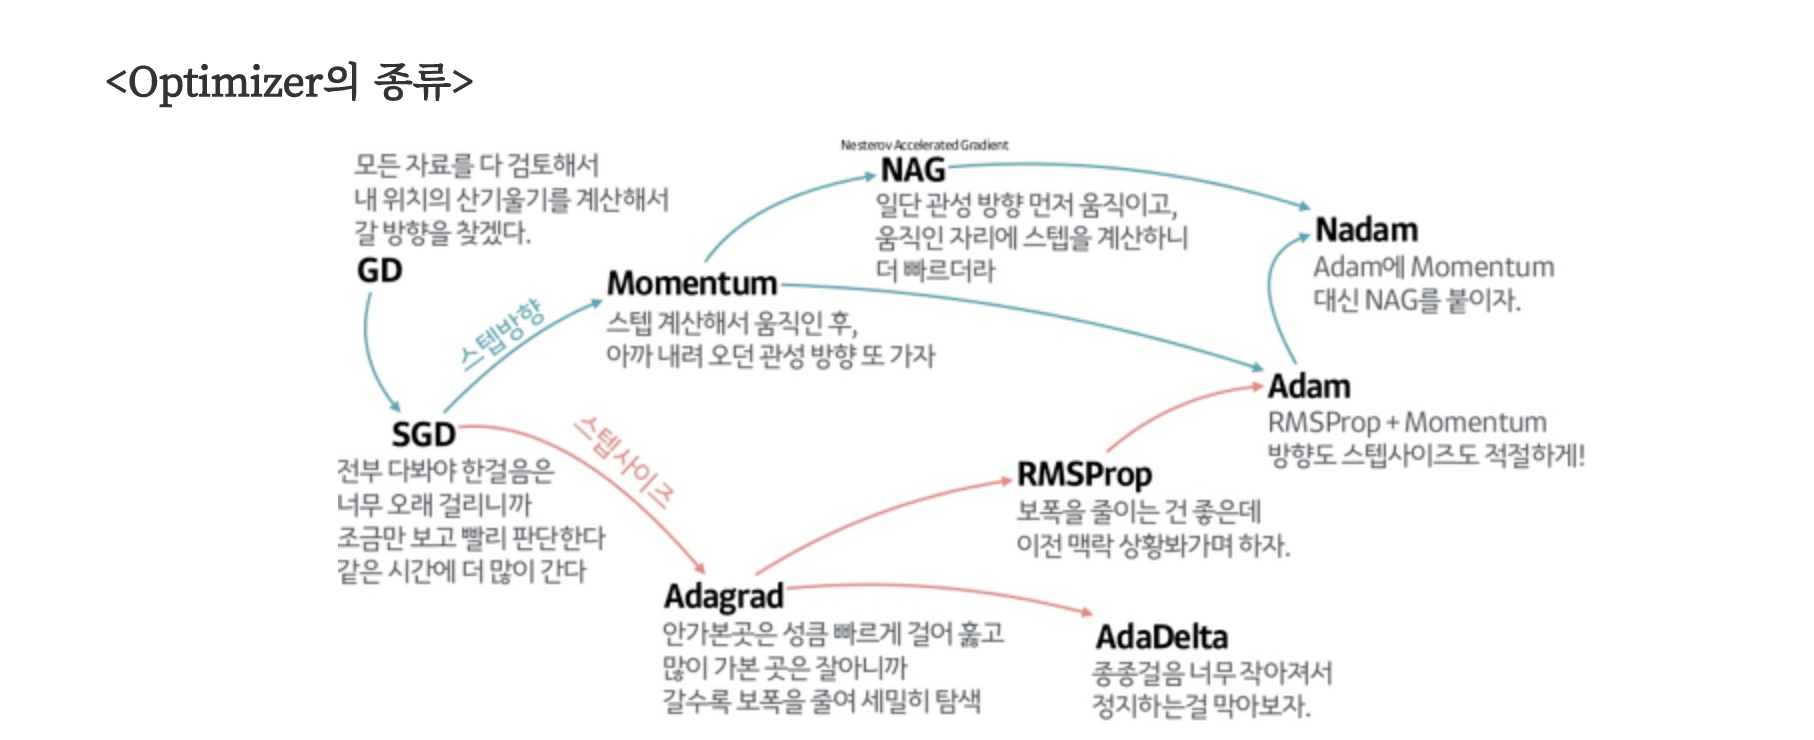

**11.3.1 모멘텀 최적화**

**Momentum optimization**은 항상 기울기만큼 이동하는 것보다 **공이 빗면을 구르듯 가속하면 더 빨리 최저점에 도달할 수 있다는 개념**으로 **그래디언트가 가속도**처럼 적용된다. 기존의 momentum vector m에 대해 b를 곱한 후 학습률 * 그래디언트를 더하여 파라미터를 이동한다. 그래디언트가 일정하다면 원래 그래디언트의 1/(1-b) 배가 종단속도가 된다. 이 기법은 스케일이 다른 입력값에 대해서도 비교적 빨라지며 local optima를 건너뛰는데에도 도움이 된다. GradientDescentOptimizer 대신 **MomentumOptimizer**를 사용하면 된다.


간단히 말해, **Momentum 방식은 말 그대로 Gradient Descent를 통해 이동하는 과정에 일종의 ‘관성’을 주는 것**
 현재 Gradient를 통해 이동하는 방향과는 별개로, 과거에 이동했던 방식을 기억하면서 그 방향으로 일정 정도를 추가적으로 이동하는 방식

 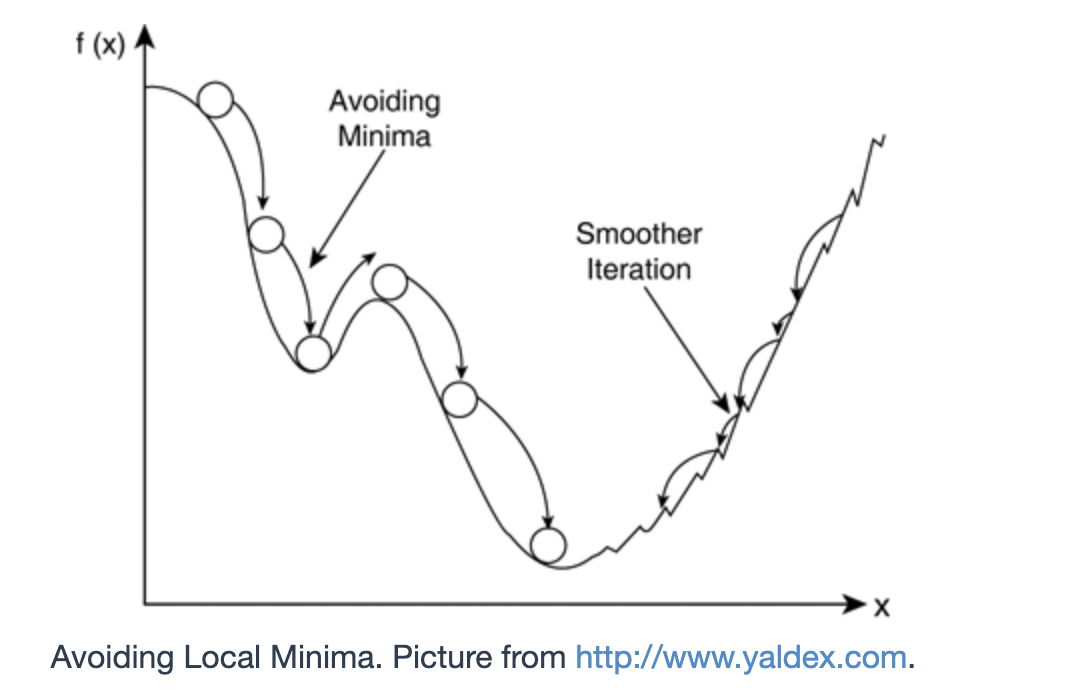



기존의 SGD를 이용할 경우 좌측의 local minima에 빠지면 gradient가 0이 되어 이동할 수가 없지만, momentum 방식의 경우 기존에 이동했던 방향에 관성이 있어 이 local minima를 빠져나오고 더 좋은 minima로 이동할 것을 기대할 수 있게 된다. 

**momentum 방식을 이용할 경우 기존의 변수들 θ 외에도 과거에 이동했던 양을 변수별로 저장해야하므로 변수에 대한 메모리가 기존의 두 배로 필요**

**11.3.2 네스테로프 가속 경사**

Nesterov Momentum optimization은 모멘텀 최적화의 변종으로, 현재 위치가 아니라 모멘텀의 방향으로 조금 앞서서 그래디언트를 계산하는 것이다. MomentumOptimizer에 user_nesterov=True를 설정하면 된다.

Nesterov Accelerated Gradient(NAG)는 **Momentum 방식을 기초로 한 방식**이지만, Gradient를 계산하는 방식이 살짝 다르다. 빠른 이해를 위해 다음 그림을 먼저 살펴보자.

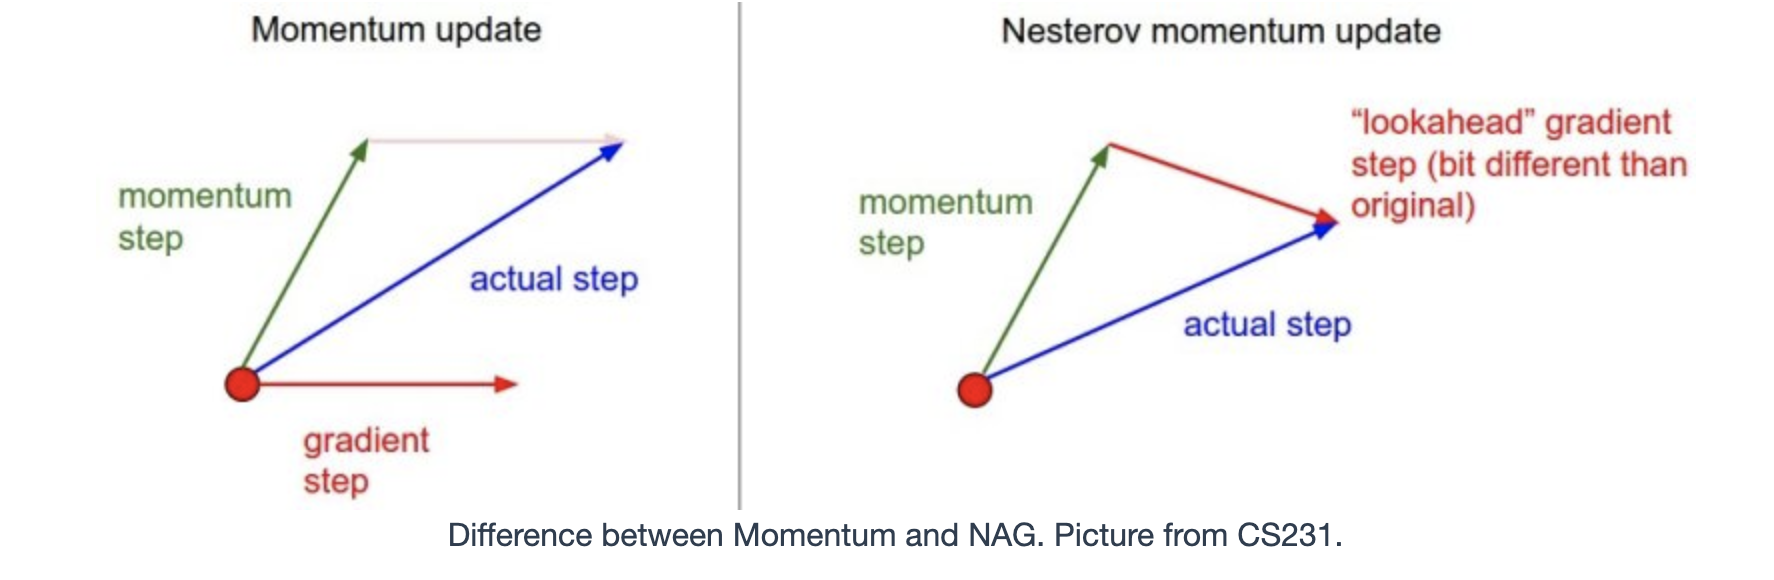

NAG를 이용할 경우 Momentum 방식에 비해 보다 효과적으로 이동할 수 있다. Momentum 방식의 경우 멈춰야 할 시점에서도 **관성에 의해 훨씬 멀리 갈수도 있다는 단점**이 존재하는 반면, NAG 방식의 경우 일단 **모멘텀으로 이동을 반정도 한 후 어떤 방식으로 이동해야할 지를 결정**한다. 따라서 **Momentum 방식의 빠른 이동에 대한 이점은 누리면서도, 멈춰야 할 적절한 시점에서 제동을 거는 데에 훨씬 용이**하다고 생각할 수 있다

**11.3.3 AdaGrad**

AdaGrad 알고리즘은 가파른 차원을 따라 그래디언트 벡터의 스케일을 감소시키는 것이다. 벡터의 스케일을 학습하는 벡터 s에 대해 각 그래디언트 원소의 제곱을 더하고, 학습률에서 각 원소에 sqrt (s + eps)를 나누어주면 각 원소의 크기가 클수록 학습률이 작아진다. 이를 adaptive learning rate라고 부른다. AdagradOptimizer를 사용하면 되지만, 심층 신경망에는 너무 일찍 멈춰버리는 경향이 있어 사용하면 안된다.

 

Adagrad(Adaptive Gradient)는 변수들을 update할 때 각각의 변수마다 step size를 다르게 설정해서 이동하는 방식이다. 이 알고리즘의 기본적인 아이디어는 **‘지금까지 많이 변화하지 않은 변수들은 step size를 크게 하고, 지금까지 많이 변화했던 변수들은 step size를 작게 하자’** 라는 것

**자주 등장하거나 변화를 많이 한 변수들의 경우 optimum에 가까이 있을 확률이 높기 때문에 작은 크기로 이동하면서 세밀한 값을 조정하고, 적게 변화한 변수들은 optimum 값에 도달하기 위해서는 많이 이동해야할 확률이 높기 때문에 먼저 빠르게 loss 값을 줄이는 방향으로 이동하려는 방식**


Adagrad를 사용하면 학습을 진행하면서 굳이 **step size decay등을 신경써주지 않아도 된다는 장점**이 있다. 보통 adagrad에서 step size로는 0.01 정도를 사용한 뒤, 그 이후로는 바꾸지 않는다. 반면, Adagrad에는 학습을 계속 진행하면 **step size가 너무 줄어든다는 문제점이 있다**. G에는 계속 제곱한 값을 넣어주기 때문에 G의 값들은 계속해서 증가하기 때문에, 학습이 오래 진행될 경우 step size가 너무 작아져서 결국 거의 움직이지 않게 된다. 

즉, **AdaGrad는 간단한 convex function에서 잘 동작하지만, 복잡한 다차원 곡면 function에서는 global minimum에 도달하기 전에 학습률이 0에 수렴할 수 있다.** 

이를 보완하여 고친 알고리즘이 **RMSProp과 AdaDelta**

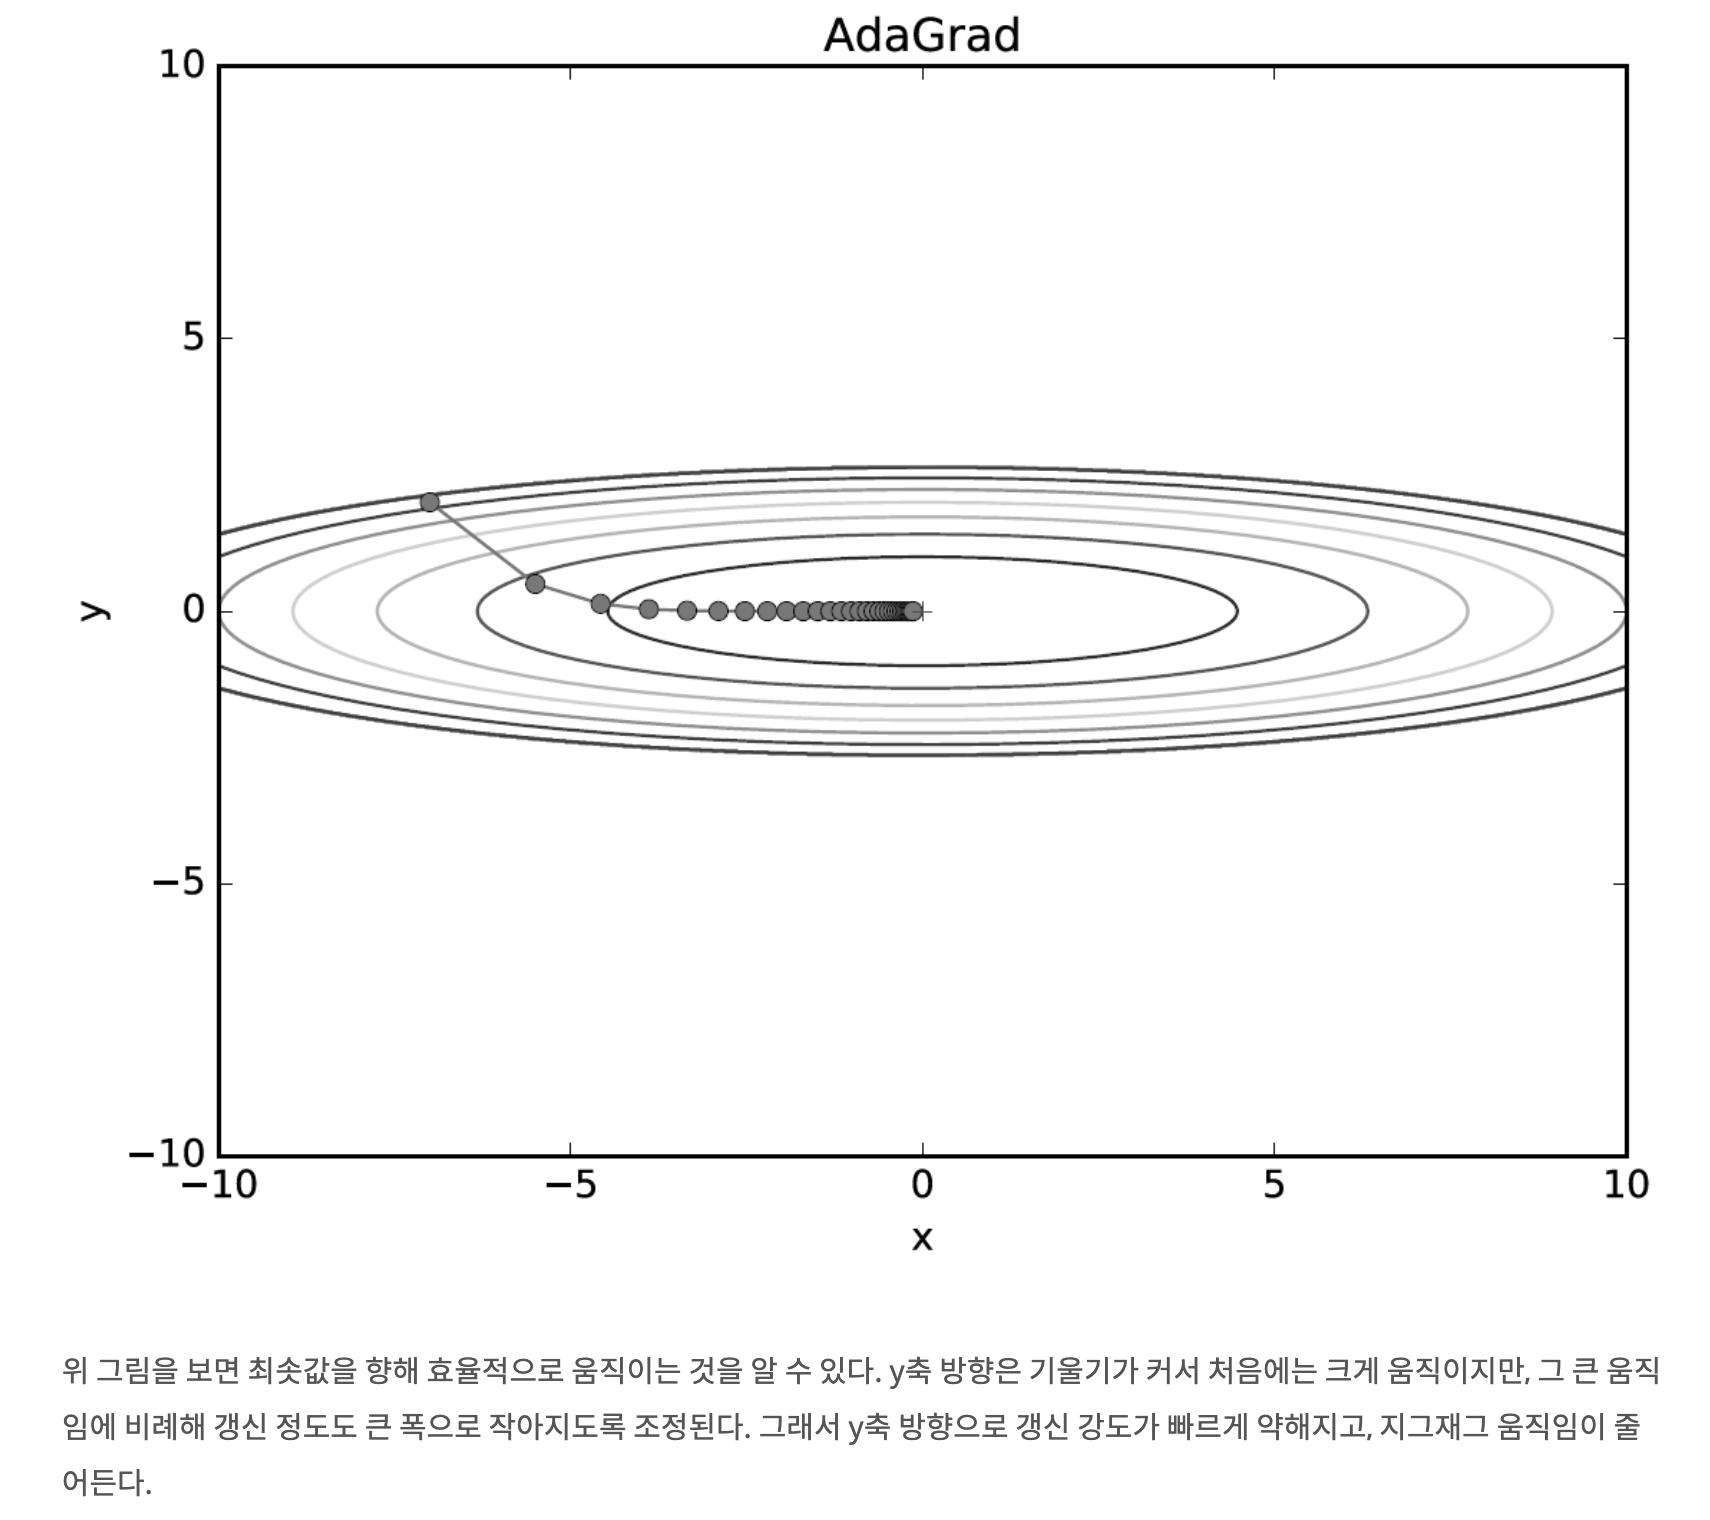

**11.3.4 RMSProp**

RMSProp 알고리즘은 AdaGrad 알고리즘에서 s를 관성을 가지고 학습하는 것이다. RMSPropOptimizer class를 사용하면 된다. 아주 간단한 문제를 제외하고는 AdaGrad보다 대부분 성능이 좋다.

 

RMSProp은 딥러닝의 대가 제프리 힌톤이 제안한 방법으로서, Adagrad의 단점을 해결하기 위한 방법이다. Adagrad의 식에서 gradient의 제곱값을 더해나가면서 구한 Gt 부분을 합이 아니라 지수평균으로 바꾸어서 대체한 방법


기타.. **AdaDelta**
AdaDelta (Adaptive Delta) 는 RMSProp과 유사하게 AdaGrad의 단점을 보완하기 위해 제안된 방법이다. AdaDelta는 **RMSProp과 동일하게 G를 구할 때 합을 구하는 대신 지수평균**을 구한다. 다만, 여기에서는 step size를 단순하게 η 로 사용하는 대신 step size의 변화값의 제곱을 가지고 지수평균 값을 사용한다.

**11.3.5 Adam 최적화**

Momentum과 RMSProp를 융합한 방법

모멘텀 최적화와 RMSProp을 합친 adaptive moment estimation (Adam)은 momentum을 그래디언트에 따라 이동 평균내고, s를 AdaGrad 방법과 같이 이동평균내며 m / sqrt(s + eps)만큼 학습한다.

 

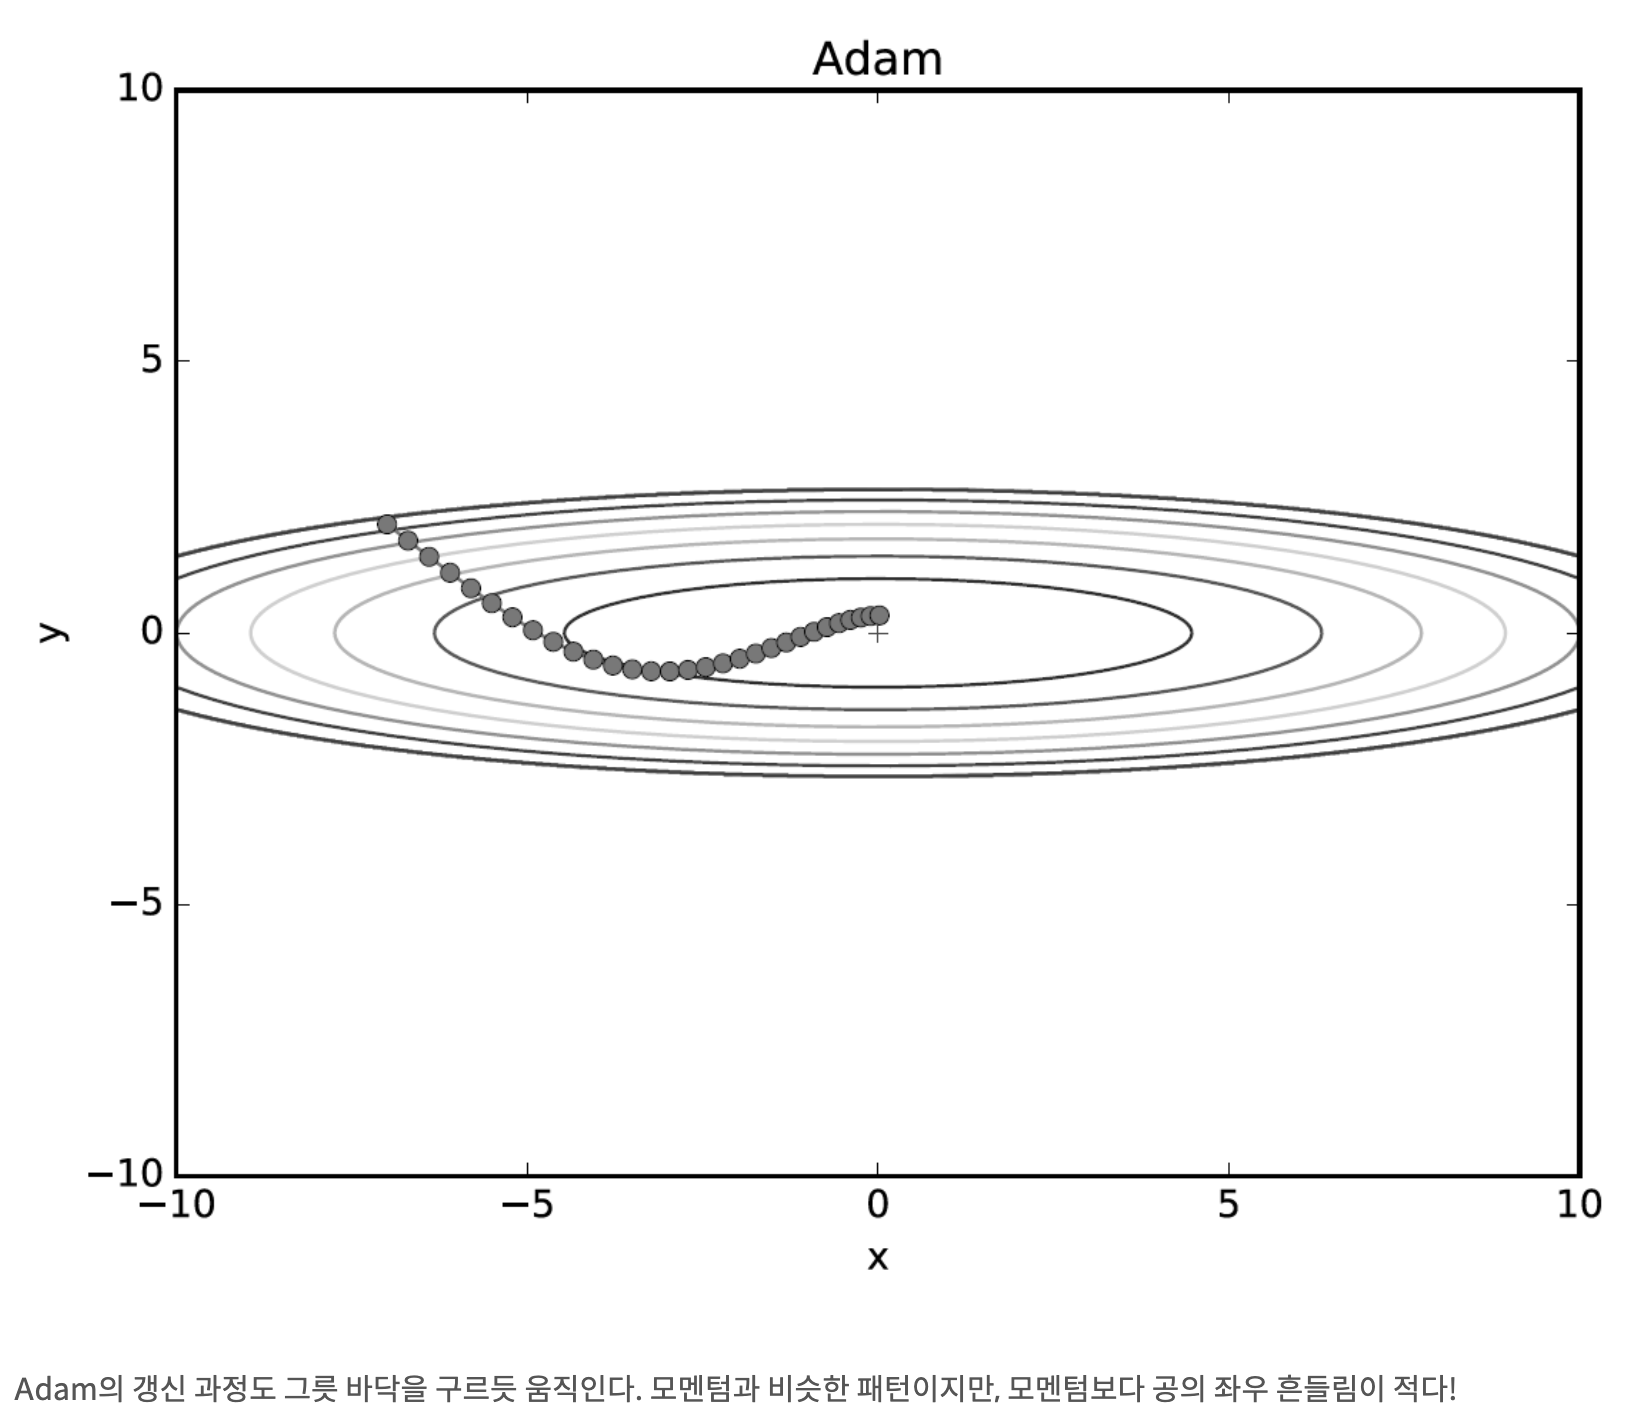

##고속 옵티마이저 summary
SGD부터 NAdam까지 모든 알고리즘을 살펴보았다. 각 알고리즘들은 이전 알고리즘들의 한계점을 보완해가며 발전해갔다.

- **SGD**는 업데이트 한 번에 데이터 하나를 사용하여 Batch GD의 시간 문제를 해결,
- **Momentum**은 SGD의 작은 gradient 때문에 작은 언덕이나 saddle point를 빠져나가지 못하는 것을 momentum을 도입하여 해결.
- **NAG**는 다음 step의 gradient를 먼저 살펴보고 Momentum을 조절하여 minimum에 안정적으로 들어감
- **Adagrad**는 업데이트 빈도가 다른 파라미터에 대해서도 같은 비율로 업데이트하는 것을 이전 gradient들의 합을 기억함으로써 문제를 해결.
-**RMSProp**과 **Adadelta**는 Adagrad의 learning rate가 점점 소실되는 것을 gradient의 2차 모먼트를 통해 보완
-**Adam**은 RMSProp에 1차 모먼트를 도입하여 RMSProp과 Momentum을 합친 효과를 냄
-**AdaMax**는 Adam의 2차 모먼트에 있는 gradient의 norm을 max norm으로 바꿔주었고
-**NAdam**은 ADAM에 NAG를 더해주어서 momentum을 보완해주었다.


위 옵티마이저 어느 알고리즘이 가장 좋다, 라고 말하기는 힘들다. 어떤 문제를 풀고있는지, 어떤 데이터셋을 사용하는지, 어떤 네트워크에 대해 적용하는지에 따라 각 방법의 성능은 판이하게 차이가 날 것이므로 실제로 네트워크를 학습시킬 때는 **다양한 시도**를 해보며 현재 경우에서는 어떤 알고리즘이 가장 성능이 좋은지에 대해 실험 필요.


여기서 설명한 알고리즘들은 모두 **Stochastic Gradient Descent**, 즉 **단순한 first-order optimization의 변형**들이다. 이 외에도 **Newton’s Method** 등 **second-order optimization**을 기반으로 한 알고리즘들도 있다. 그러나 단순한 second-order optimization을 사용하기 위해서는 **Hessian Matrix라는 2차 편미분 행렬을 계산한 후 역행렬을 구해야 하는데, 이 계산과정이 계산적으로 비싼 작업이기 때문에 보통 잘 사용되지 않는다.** 이러한 계산량을 줄이기 위해 hessian matrix를 근사하거나 추정해나가면서 계산을 진행하는 BFGS / L-BFGS 등의 알고리즘, 그리고 hessian matrix를 직접 계산하지 않으면서 second-order optimization인 Hessian-Free Optimization 등도 존재

**11.3.6 학습률 스케줄링**
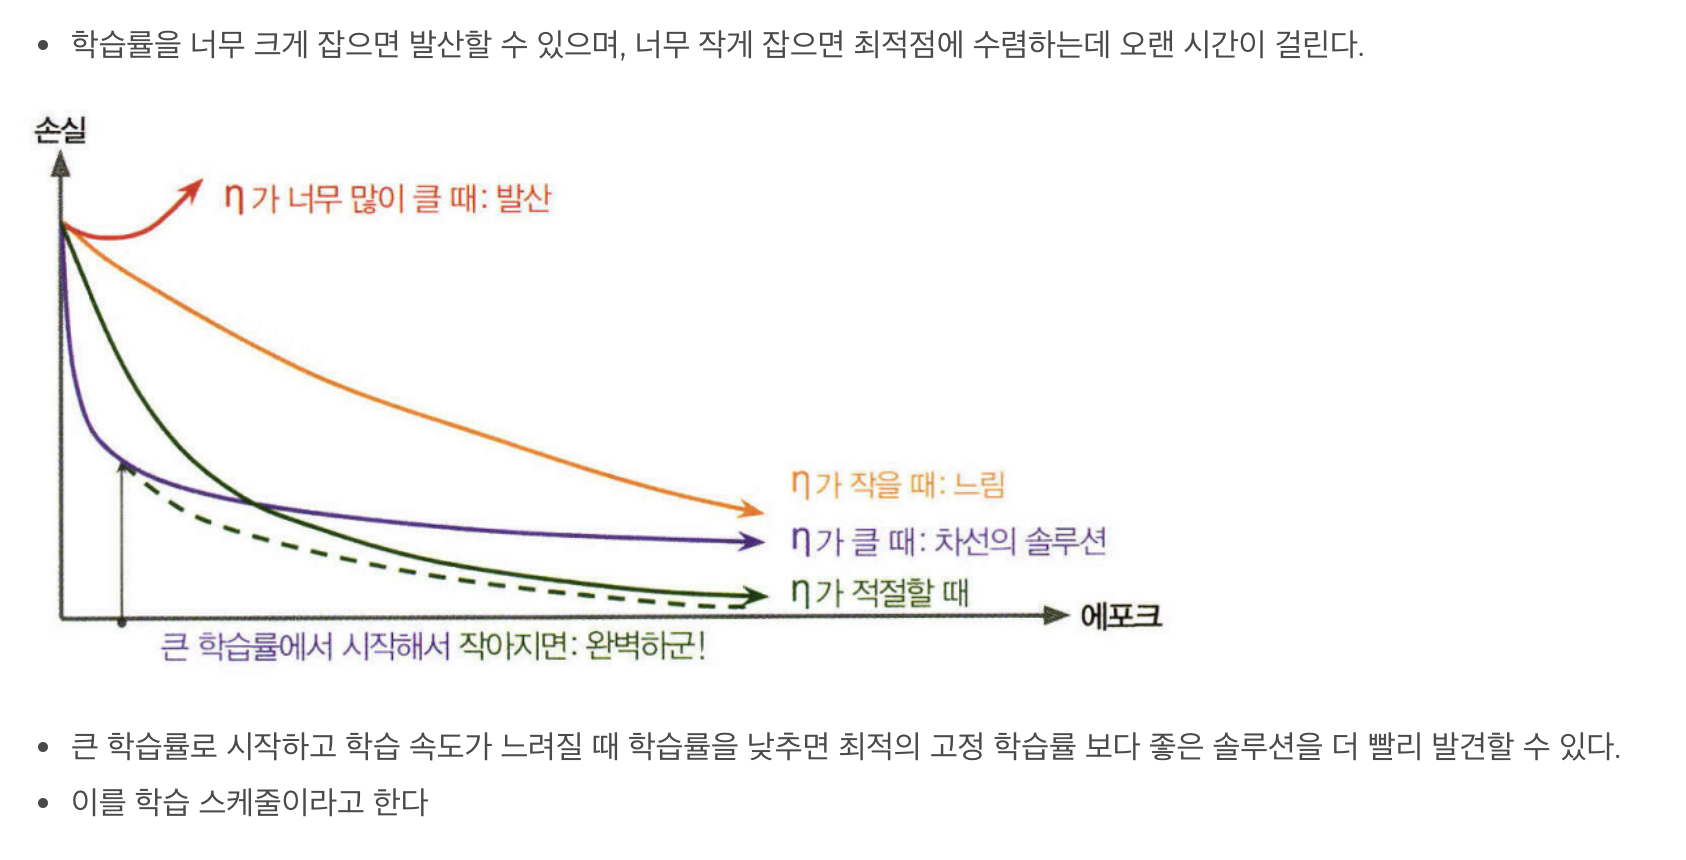

처음에는 빠르게 학습하고 나중에는 천천히 학습하는 것이 도움이 된다. 이를 위해 여러 가지 학습 스케줄 전략이 있다.

- 미리 정해둔 학습률을 특정 시점 이후에 적용(학습률을 정하기 위해 여러 시도를 해봐야 한다는 단점)

- 매 N스텝 마다 검증 오차를 측정하고 오차가 줄어들지 않는 경우 학습률 감소

- 반복 횟수에 따라 지수적으로 학습률 감소 (감소율 튜닝 필요)

- 다항식을 분모로 학습률 감소 (지수 기반 보다 느리게 감소)

 

주로 지수 기반 스케줄링을 사용한다. tf.train.exponential_decay를 이용하여 학습률을 직접 적용하고, 이 떄 사용되는 global_step은 학습에서 제외하여야 한다.


AdaGrad, RMSProp, Adam 최적화는 학습률을 알아서 감소시켜준다.

 

**11.4 과대적합을 피하기 위한 규제 방법**
파라미터가 많으므로 과대적합 될 위험이 있다. 따라서 여러 규제를 적용하여야 한다.

**11.4.1 조기 종료**

일정한 간격으로 Validation Data로 평가하여 성능이 떨어지려고 하면 중단하는 조기 종료 방법을 사용할 수 있다.


**11.4.2 l1과 l2 규제**

선형 회귀에 대해 했던 것 처럼 l1이나 l2규제를 적용하여 (일반적으로 bias는 제외) 제약을 가할 수 있다. layer를 선언할 때에 kernel_regularizer에 l1_regularizer(), l2_regularizer(), l1_l2_regularizer() 함수 등을 적용할 수 있다. 이 때 REGULARIZATION_LOSSES collections에서 연산들을 불러와 기존의 loss에 더해주어 새로운 loss를 정의하여야 한다.

 

**11.4.3 드롭아웃**

매 훈련 스텝에서 각 뉴런은 무시 될 확률 p를 가진다. 주로 p는 0.5를 사용한다. p를 드롭아웃 비율이라고 한다. 훈련 이후에는 드롭아웃을 적용하지 않는다. 이는 특징을 특정 뉴런에만 맡기지 않고 임의의 뉴런에 맡길 수 있으므로 일반적으로 좋은 성능을 가지게 된다. 매번 다른 신경망에 학습하는 효과가 있으므로 앙상블과 같은 효과를 얻을 수도 있다. 대신 테스트하는 동안 한 뉴런이 훈련때보다 평균적으로 1/(1-p)배 많은 입력 뉴런과 연결되므로 보존확률 (1-p)으로 계수를 나누어줄 필요가 있다.

 

**11.4.4 맥스-노름 규제**

널리 사용되는 다른 규제기법은 **max-norm regularization**이다. 각각의 뉴런에 대해 입력의 연결 가중치 w의 2-norm이 r이하가 되도록 제한한다. 일반적으로 w를 클리핑한다. clip_by_norm() 함수를 사용할 수 있다.

 

**11.4.5 데이터 증식**

기존의 데이터에서 새로운 데이터를 생성해 훈련 세트를 늘리는데, 단순한 백색소음은 도움이 되지 않는다. 예를 들어 이미지를 약간 회전하거나 약간 이동하거나 명암을 약간 다르게 한다면 많은 명암, 각도, 이동에 대해 학습할 수 있을 것이다.

 



**11.5 실용적 가이드라인**
주로 활용할 수 있는 가이드 라인.

[He 초기화, ELU 활성화 함수, 배치 정규화, 드롭아웃, 네스테로프 가속 경사, 학습률 스케줄링 없음]

 